###Implementación de LSTM para predicción de trayectoria de peatones

In [ ]:
#!unzip '/content/drive/MyDrive/ProyectoSL2/data/stanford-dataset-meters.zip' -d '/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters'


Instalación de wandb para observar el comportamiento de los parametros del modelo

In [ ]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import wandb
from wandb.keras import WandbCallback

wandb.init(project="ProyectoSL2")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: silvya. Use `wandb login --relogin` to force relogin


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf

####Preparación de Datos a utilizar

In [ ]:
#Funcion para dividir una sequencia multivariable en muestras
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# Encontrar el final del patron
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		
		if out_end_ix > len(sequences): # verificar que si se llego al final del dataset
			break
		
		# unir entradas y salidas del patron
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [ ]:
from random import Random	

#funcion para preparar la estructura de los datos para poder utilizarlo con estructura de aprendizaje supervisado
def sequences_to_supervised(dataframe, n_steps_in, n_steps_out, n_features):
  X_all = np.empty([0,n_steps_in,n_features]) # n_features = number of features: x, y
  y_all = np.empty([0,n_steps_out,n_features]) # n_features = number of features: x,y
       
  dataframe_groups = dataframe.groupby(['id']) #se agrupan las secuencias de cada peaton
  
  groups = list(dataframe.groupby(['id'])) 
  Random(1).shuffle(groups)  #secuencias aleatorias agrupadas por el id del peaton
 

  for group in groups:
    X, y = split_sequences(group[1].drop(columns=["id"]).values, n_steps_in,n_steps_out) # 2 features, x, y
         
    X_all = np.concatenate((X_all,X))
    y_all = np.concatenate((y_all,y))
                   
  return X_all, y_all      

In [ ]:
n_features = 2   # features x, y (posicion del peaton en un tiempo t)
n_steps_in = 8   # 8 pasos de entrada (secuencia de trayectoria inicial)
n_steps_out = 12 # 12 pasos de salida (secuencia de trayectoria a predecir)

Extracción y carga de datos a utilizar para el entrenamiento del modelo

In [ ]:
#los datos se encuentran en archivos por separado, se unen archivos para el training data
train_files = ['/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/train/bookstore_0.txt',
               '/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/train/bookstore_1.txt',
               '/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/train/bookstore_2.txt']

df =pd.DataFrame()

for i in range(len(train_files)):
  data = pd.read_csv(train_files[i],sep=' ', header=None, names=['time','id','x','y'])
  data['id'] = data['id'].apply(lambda x: str(i)+str(x))

  df = pd.concat([df,data],ignore_index=True)

El dataset contiene cuatro columnas 

**id:** el id del peaton

**time:** contiene el tiempo de la secuencia de trayectoria de un peaton, son 20 timestep por cada peaton.

**x:** coordenada x en metros de la posición en un punto de la secuencia de trayectoria 

**y:** coordenada y en metros de la posicion en un punto de la secuencia de trayectoria 

In [ ]:
df.head(40)

,time,id,x,y
0,0,0100,1.728,14.378
1,12,0100,2.035,14.378
2,24,0100,2.342,14.378
3,36,0100,2.630,14.378
4,48,0100,2.937,14.416
5,60,0100,3.244,14.416
6,72,0100,3.551,14.416
7,84,0100,3.782,14.416
8,96,0100,4.089,14.416
9,108,0100,4.242,14.512


El dataset contiene en total 1772 trayectorias

Las posiciones son de una imagen en un plano con coordenadas (x,y), con el origen en medio de la imagen, por esto se tienen coordenas positivas y negativas. 

Coordenadas  -28.579 < x < 28.518, -21.754 < y < 21.714

Con lo que se obtiene un área de estudio de 2481.89 metros cuadrados

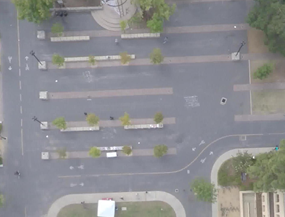

In [ ]:
df.describe(include='all')

,time,id,x,y
count,35440.000000,35440,35440.000000,35440.000000
unique,NaN,1772,NaN,NaN
top,NaN,0100,NaN,NaN
freq,NaN,20,NaN,NaN
mean,7143.284424,NaN,-1.710165,2.422755
std,4040.345357,NaN,14.818010,12.437575
min,0.000000,NaN,-28.579000,-21.754000
25%,3552.000000,NaN,-14.005250,-9.175000
50%,7332.000000,NaN,-3.321000,2.380000
75%,10536.000000,NaN,9.291000,15.683000


Normalización de los datos de entrenamiento:

In [ ]:
from sklearn.preprocessing import MinMaxScaler

id_column = df.id
df.drop(columns=['time','id'], axis=1, inplace=True) #se quita la feature time del dataset

#Normalizando datos de posición
scaler = MinMaxScaler()
df = pd.DataFrame(scaler.fit_transform(df), columns=df.columns) #se normalizan unicamente las feature x,y

df['id'] = id_column

import pickle as pkl
with open('/content/drive/MyDrive/ProyectoSL2/data/models/LSTM/scaler.pkl', 'wb') as outfile: #se guarda el scaler para poder desnormalizar despues los datos
  pkl.dump(scaler, outfile)

Training data normalizados:

In [ ]:
df.head(5)

,x,y,id
0,0.530798,0.831232,0100
1,0.536175,0.831232,0100
2,0.541552,0.831232,0100
3,0.546596,0.831232,0100
4,0.551973,0.832106,0100


In [ ]:
#división de features x, y para utilizarlos en el modelo de entrada multiple
X,y = sequences_to_supervised(df,n_steps_in,n_steps_out, n_features)


In [ ]:
print(X.shape) #1772 muestras, de 8 pasos de entrada, con 2 caracteristicas (posicion coordenadas x,y)
print(y.shape) #1772 muestras, de 12 pasos de salida, con 2 caracteristicas (posicion coordenadas x,y)

(1772, 8, 2)
(1772, 12, 2)


In [ ]:
print("X:",X.shape[0],"muestras, de",X.shape[1],"pasos de entrada, con",X.shape[2],"caracteristicas que corresponden a las coordenadas de la posición")
print("y:",y.shape[0],"muestras, de",y.shape[1],"pasos de salida, con",y.shape[2],"caracteristicas que corresponden a las coordenadas de la posición")

X: 1772 muestras, de 8 pasos de entrada, con 2 caracteristicas que corresponden a las coordenadas de la posición
y: 1772 muestras, de 12 pasos de salida, con 2 caracteristicas que corresponden a las coordenadas de la posición


In [ ]:
#se redimensionan los datos para poder procesarlos con MLP
# flatten input
#n_input = X.shape[1] * X.shape[2] #dimension input 
#X_flatten = X.reshape((X.shape[0], n_input)) #805,16

# flatten conditional y
#n_input = y.shape[1] * y.shape[2] #dimension output
#y_flatten = y.reshape((y.shape[0],n_input)) #805,24


In [ ]:
#print(X_flatten[0]) 
#print(y_flatten[0])

####Creación modelo LSTM

#####Creación de la estructura:

In [ ]:
n_timesteps = 8
n_features = 2
n_outputs =12

input_layer=tf.keras.Input(shape=(n_timesteps, n_features))

encoder = tf.keras.layers.LSTM(512,return_sequences=False)(input_layer)  #ref libro 20.8

#encoder = tf.keras.layers.LSTM(128,return_sequences=True)(input_layer)  #ref libro 20.8
#encoder = tf.keras.layers.LSTM(128,return_sequences=False)(encoder)

latent_vector = tf.keras.layers.RepeatVector(n_outputs)(encoder)
decoder = tf.keras.layers.LSTM(512,return_sequences=True)(latent_vector)
decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(2, activation='linear'))(decoder)

model = tf.keras.Model(input_layer, decoder)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, epsilon=1e-08, decay=0.0), loss='mse') #problema de regresion


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8, 2)]            0         
                                                                 
 lstm (LSTM)                 (None, 512)               1054720   
                                                                 
 repeat_vector (RepeatVector  (None, 12, 512)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 12, 512)           2099200   
                                                                 
 time_distributed (TimeDistr  (None, 12, 2)            1026      
 ibuted)                                                         
                                                                 
Total params: 3,154,946
Trainable params: 3,154,946
Non-train

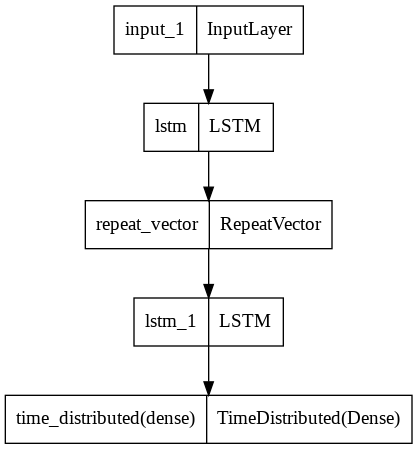

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
#callback para monitorear el costo
wandb_callback = WandbCallback(monitor='val_loss', mode='min', log_gradients=False)

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


#####Entrenamiento del modelo:

In [ ]:
model.fit(X,y, epochs=400, validation_split=0.2, callbacks=[wandb_callback], batch_size=32)

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


Epoch 1/400
45/45 [==============================] - ETA: 0s - loss: 0.0233

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 39s 766ms/step - loss: 0.0233 - val_loss: 0.0031
Epoch 2/400
45/45 [==============================] - ETA: 0s - loss: 0.0039

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 25s 565ms/step - loss: 0.0039 - val_loss: 0.0025
Epoch 3/400
45/45 [==============================] - 15s 343ms/step - loss: 0.0030 - val_loss: 0.0027
Epoch 4/400
45/45 [==============================] - ETA: 0s - loss: 0.0029

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 24s 545ms/step - loss: 0.0029 - val_loss: 0.0024
Epoch 5/400
45/45 [==============================] - 17s 369ms/step - loss: 0.0030 - val_loss: 0.0043
Epoch 6/400
45/45 [==============================] - 15s 333ms/step - loss: 0.0031 - val_loss: 0.0024
Epoch 7/400
45/45 [==============================] - ETA: 0s - loss: 0.0023

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 24s 537ms/step - loss: 0.0023 - val_loss: 0.0019
Epoch 8/400
45/45 [==============================] - ETA: 0s - loss: 0.0022

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 24s 544ms/step - loss: 0.0022 - val_loss: 0.0018
Epoch 9/400
45/45 [==============================] - 15s 341ms/step - loss: 0.0021 - val_loss: 0.0022
Epoch 10/400
45/45 [==============================] - ETA: 0s - loss: 0.0021

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 24s 548ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 11/400
45/45 [==============================] - 15s 344ms/step - loss: 0.0016 - val_loss: 0.0027
Epoch 12/400
45/45 [==============================] - 15s 343ms/step - loss: 0.0021 - val_loss: 0.0014
Epoch 13/400
45/45 [==============================] - ETA: 0s - loss: 0.0013

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 24s 531ms/step - loss: 0.0013 - val_loss: 0.0011
Epoch 14/400
45/45 [==============================] - 16s 346ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 15/400
45/45 [==============================] - 17s 382ms/step - loss: 0.0012 - val_loss: 0.0020
Epoch 16/400
45/45 [==============================] - ETA: 0s - loss: 0.0014

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 24s 549ms/step - loss: 0.0014 - val_loss: 0.0010
Epoch 17/400
45/45 [==============================] - 15s 343ms/step - loss: 0.0012 - val_loss: 0.0010
Epoch 18/400
45/45 [==============================] - ETA: 0s - loss: 9.3887e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 26s 583ms/step - loss: 9.3887e-04 - val_loss: 7.5636e-04
Epoch 19/400
45/45 [==============================] - 15s 342ms/step - loss: 9.1595e-04 - val_loss: 7.8826e-04
Epoch 20/400
45/45 [==============================] - 17s 376ms/step - loss: 9.8770e-04 - val_loss: 8.2856e-04
Epoch 21/400
45/45 [==============================] - 15s 328ms/step - loss: 7.8272e-04 - val_loss: 8.9022e-04
Epoch 22/400
45/45 [==============================] - 15s 329ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 23/400
45/45 [==============================] - 16s 346ms/step - loss: 0.0011 - val_loss: 8.1215e-04
Epoch 24/400
45/45 [==============================] - ETA: 0s - loss: 9.0471e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.9s


45/45 [==============================] - 30s 672ms/step - loss: 9.0471e-04 - val_loss: 6.5232e-04
Epoch 25/400
45/45 [==============================] - 15s 339ms/step - loss: 9.6750e-04 - val_loss: 0.0011
Epoch 26/400
45/45 [==============================] - ETA: 0s - loss: 7.7288e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 25s 550ms/step - loss: 7.7288e-04 - val_loss: 6.5207e-04
Epoch 27/400
45/45 [==============================] - 15s 333ms/step - loss: 7.2074e-04 - val_loss: 7.5947e-04
Epoch 28/400
45/45 [==============================] - 17s 377ms/step - loss: 9.8064e-04 - val_loss: 7.6506e-04
Epoch 29/400
45/45 [==============================] - ETA: 0s - loss: 6.5746e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 24s 537ms/step - loss: 6.5746e-04 - val_loss: 4.4186e-04
Epoch 30/400
45/45 [==============================] - 16s 356ms/step - loss: 9.4166e-04 - val_loss: 5.3068e-04
Epoch 31/400
45/45 [==============================] - 15s 338ms/step - loss: 7.4925e-04 - val_loss: 5.1646e-04
Epoch 32/400
45/45 [==============================] - 15s 335ms/step - loss: 6.6542e-04 - val_loss: 4.9100e-04
Epoch 33/400
45/45 [==============================] - 15s 337ms/step - loss: 7.4530e-04 - val_loss: 7.6627e-04
Epoch 34/400
45/45 [==============================] - ETA: 0s - loss: 6.0939e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 26s 580ms/step - loss: 6.0939e-04 - val_loss: 4.1955e-04
Epoch 35/400
45/45 [==============================] - 15s 341ms/step - loss: 5.0779e-04 - val_loss: 0.0013
Epoch 36/400
45/45 [==============================] - 15s 334ms/step - loss: 9.6151e-04 - val_loss: 5.0683e-04
Epoch 37/400
45/45 [==============================] - 15s 330ms/step - loss: 7.1014e-04 - val_loss: 6.6167e-04
Epoch 38/400
45/45 [==============================] - ETA: 0s - loss: 5.0627e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 25s 564ms/step - loss: 5.0627e-04 - val_loss: 3.1783e-04
Epoch 39/400
45/45 [==============================] - ETA: 0s - loss: 5.0993e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 24s 549ms/step - loss: 5.0993e-04 - val_loss: 2.9145e-04
Epoch 40/400
45/45 [==============================] - ETA: 0s - loss: 4.1166e-04

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 23s 526ms/step - loss: 4.1166e-04 - val_loss: 2.2967e-04
Epoch 41/400
45/45 [==============================] - 15s 331ms/step - loss: 3.7326e-04 - val_loss: 2.7229e-04
Epoch 42/400
45/45 [==============================] - 15s 329ms/step - loss: 5.8370e-04 - val_loss: 4.2708e-04
Epoch 43/400
45/45 [==============================] - 15s 331ms/step - loss: 5.5012e-04 - val_loss: 7.7303e-04
Epoch 44/400
45/45 [==============================] - 16s 347ms/step - loss: 5.4598e-04 - val_loss: 6.1139e-04
Epoch 45/400
45/45 [==============================] - 16s 359ms/step - loss: 4.5879e-04 - val_loss: 2.8211e-04
Epoch 46/400
45/45 [==============================] - 15s 335ms/step - loss: 4.0618e-04 - val_loss: 3.5025e-04
Epoch 47/400
45/45 [==============================] - 15s 338ms/step - loss: 4.0982e-04 - val_loss: 3.4641e-04
Epoch 48/400
45/45 [==============================] - 15s 339ms/step - loss: 4.4338e-04 - val_loss: 8.2314e-04
Epoch 49/400
4

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 27s 601ms/step - loss: 3.4692e-04 - val_loss: 1.9346e-04
Epoch 101/400
45/45 [==============================] - 17s 370ms/step - loss: 3.3010e-04 - val_loss: 2.9779e-04
Epoch 102/400
45/45 [==============================] - 17s 372ms/step - loss: 6.0072e-04 - val_loss: 6.8279e-04
Epoch 103/400
45/45 [==============================] - 18s 411ms/step - loss: 4.3699e-04 - val_loss: 3.2808e-04
Epoch 104/400
45/45 [==============================] - 17s 369ms/step - loss: 3.4291e-04 - val_loss: 3.3908e-04
Epoch 105/400
45/45 [==============================] - 16s 364ms/step - loss: 3.4810e-04 - val_loss: 2.8189e-04
Epoch 106/400
45/45 [==============================] - 16s 363ms/step - loss: 3.0655e-04 - val_loss: 2.1201e-04
Epoch 107/400
45/45 [==============================] - 16s 360ms/step - loss: 3.6888e-04 - val_loss: 3.2901e-04
Epoch 108/400
45/45 [==============================] - 16s 359ms/step - loss: 3.8300e-04 - val_loss: 4.4315e-04
Epoch 

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 24s 537ms/step - loss: 2.8430e-04 - val_loss: 1.7329e-04
Epoch 173/400
45/45 [==============================] - 15s 343ms/step - loss: 2.6648e-04 - val_loss: 2.3652e-04
Epoch 174/400
45/45 [==============================] - 15s 344ms/step - loss: 2.9381e-04 - val_loss: 2.5514e-04
Epoch 175/400
45/45 [==============================] - 15s 336ms/step - loss: 3.5636e-04 - val_loss: 2.8241e-04
Epoch 176/400
45/45 [==============================] - 15s 339ms/step - loss: 2.5090e-04 - val_loss: 2.4985e-04
Epoch 177/400
45/45 [==============================] - 17s 387ms/step - loss: 3.0482e-04 - val_loss: 1.7907e-04
Epoch 178/400
45/45 [==============================] - 16s 345ms/step - loss: 2.4766e-04 - val_loss: 2.9015e-04
Epoch 179/400
45/45 [==============================] - 16s 353ms/step - loss: 3.0668e-04 - val_loss: 2.6858e-04
Epoch 180/400
45/45 [==============================] - 16s 350ms/step - loss: 2.5512e-04 - val_loss: 2.2819e-04
Epoch 

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 25s 555ms/step - loss: 2.0131e-04 - val_loss: 1.6554e-04
Epoch 264/400
45/45 [==============================] - 15s 331ms/step - loss: 2.2460e-04 - val_loss: 2.3481e-04
Epoch 265/400
45/45 [==============================] - 15s 329ms/step - loss: 2.8401e-04 - val_loss: 2.3935e-04
Epoch 266/400
45/45 [==============================] - 15s 334ms/step - loss: 2.3572e-04 - val_loss: 3.2363e-04
Epoch 267/400
45/45 [==============================] - 15s 343ms/step - loss: 2.4543e-04 - val_loss: 2.3607e-04
Epoch 268/400
45/45 [==============================] - 18s 398ms/step - loss: 2.3629e-04 - val_loss: 2.2187e-04
Epoch 269/400
45/45 [==============================] - 16s 357ms/step - loss: 2.8279e-04 - val_loss: 2.5932e-04
Epoch 270/400
45/45 [==============================] - 17s 388ms/step - loss: 2.5817e-04 - val_loss: 2.0950e-04
Epoch 271/400
45/45 [==============================] - 16s 341ms/step - loss: 2.4167e-04 - val_loss: 1.8792e-04
Epoch 

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.3s


45/45 [==============================] - 27s 596ms/step - loss: 2.2253e-04 - val_loss: 1.6014e-04
Epoch 345/400
45/45 [==============================] - 18s 404ms/step - loss: 2.0367e-04 - val_loss: 2.1423e-04
Epoch 346/400
45/45 [==============================] - 16s 342ms/step - loss: 2.1553e-04 - val_loss: 2.0937e-04
Epoch 347/400
45/45 [==============================] - 15s 332ms/step - loss: 2.1070e-04 - val_loss: 2.1898e-04
Epoch 348/400
45/45 [==============================] - 15s 333ms/step - loss: 2.2189e-04 - val_loss: 1.8030e-04
Epoch 349/400
45/45 [==============================] - 15s 335ms/step - loss: 2.3170e-04 - val_loss: 2.3436e-04
Epoch 350/400
45/45 [==============================] - 15s 330ms/step - loss: 2.1495e-04 - val_loss: 2.4182e-04
Epoch 351/400
45/45 [==============================] - 15s 335ms/step - loss: 2.1741e-04 - val_loss: 1.9901e-04
Epoch 352/400
45/45 [==============================] - 15s 332ms/step - loss: 2.1204e-04 - val_loss: 2.5633e-04
Epoch 

wandb: Adding directory to artifact (/content/wandb/run-20220919_165344-1kvrn8lk/files/model-best)... Done. 0.4s


45/45 [==============================] - 26s 573ms/step - loss: 1.9192e-04 - val_loss: 1.5960e-04
Epoch 385/400
45/45 [==============================] - 15s 338ms/step - loss: 1.8317e-04 - val_loss: 1.7492e-04
Epoch 386/400
45/45 [==============================] - 16s 346ms/step - loss: 1.8514e-04 - val_loss: 2.1865e-04
Epoch 387/400
45/45 [==============================] - 15s 336ms/step - loss: 2.2366e-04 - val_loss: 2.8929e-04
Epoch 388/400
45/45 [==============================] - 17s 386ms/step - loss: 2.1333e-04 - val_loss: 1.8531e-04
Epoch 389/400
45/45 [==============================] - 17s 382ms/step - loss: 1.9702e-04 - val_loss: 2.4973e-04
Epoch 390/400
45/45 [==============================] - 15s 341ms/step - loss: 1.9084e-04 - val_loss: 2.0235e-04
Epoch 391/400
45/45 [==============================] - 15s 341ms/step - loss: 1.9863e-04 - val_loss: 2.1925e-04
Epoch 392/400
45/45 [==============================] - 15s 343ms/step - loss: 2.0014e-04 - val_loss: 1.7778e-04
Epoch 

In [ ]:
# se guara el modelo ya entrenado
model.save('/content/drive/MyDrive/ProyectoSL2/data/models/LSTM_1c_512u_400ep')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/ProyectoSL2/data/models/LSTM_1c_512u_400ep')

#####Metricas del modelo

In [ ]:
score = model.evaluate(X, y, verbose=1, batch_size=8)

print("\n")
print(model.metrics_names)
print(score)

222/222 [==============================] - 8s 32ms/step - loss: 1.8763e-04


['loss']
0.00018763278785627335


In [ ]:
results = model.predict(X) #predicción del modelo

In [ ]:
results = results.reshape(results.shape[0], 12, 2)  #Redimensionamiento de datos de predicción


**Metricas:**

**Average Displacement Error, ADE**: distancia euclidiana promedio sobre todos los puntos predichos y puntos reales de todos los peatones. 

**Final Displacement Error, FDE**: distancia euclideana promedio entre la posición predicha final y la posición real final de todos los peatones.

In [ ]:
import math
def average_displacement_error(pred,ground): # calculo Error de una trayectoria
 
  e = []
 
  for p,g in zip(pred,ground):
    e.append( math.sqrt (((p[0] - g[0]) ** 2) + ((p[1] - g[1]) ** 2)))
 
  return np.sum(e)/len(e),e[len(e)-1]   #ADE,FDE


In [ ]:
def calculate_error_batch(results, ground): #calculo de Error para todas las trayetorias
 
  ADE = []
  FDE = [] 
 
  for r, g in zip(results, ground):
    a,f = average_displacement_error(r,g)
    ADE.append(a)
    FDE.append(f)
    
  return np.sum(ADE)/len(ADE),np.sum(FDE)/len(FDE)


#####Visualización de resultados con datos de entrenamiento

In [ ]:
import matplotlib.pyplot as plt
#Funcion para visualizar trayectoria
def print_trayectoria(prev_list, ground_list, prediction_list,n):
  prev = prev_list[n]
  ground = ground_list[n]
  prediction = prediction_list[n]
  
  prev = tf.transpose(prev,[1,0])
  ground = tf.transpose(ground,[1,0])
  prediction = tf.transpose(prediction,[1,0])

  fig, ax =plt.subplots(1,1,figsize=(4,4))
  ax.set_aspect('equal', adjustable='datalim')
  ax.plot(prev[0], prev[1], '-o',color='gray',linestyle='dashed')

  ax.plot(ground[0],ground[1],'-o', color='green',linestyle='dashed')
  ax.plot(prediction[0],prediction[1],'-o', color='red',linestyle='dashed')
  
  plt.show()

Denormalización de datos:

In [ ]:
with open('/content/drive/MyDrive/ProyectoSL2/data/models/LSTM/scaler.pkl','rb') as f:
  scaler = pkl.load(f)

#redimensionamiento para tener un array en 2D y poder denormalizar X
X_denormalized = np.array(X)
X_denormalized = X_denormalized.reshape(X_denormalized.shape[0]*X_denormalized.shape[1],X_denormalized.shape[2])
X_denormalized =  scaler.inverse_transform(X_denormalized)
X_denormalized = X_denormalized.reshape(X.shape[0],X.shape[1],X.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Y
Y_denormalized = np.array(y)
Y_denormalized = Y_denormalized.reshape(Y_denormalized.shape[0]*Y_denormalized.shape[1],Y_denormalized.shape[2])
Y_denormalized =  scaler.inverse_transform(Y_denormalized)
Y_denormalized = Y_denormalized.reshape(y.shape[0],y.shape[1],y.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Results
results_denormalized = np.array(results)
results_denormalized = results_denormalized.reshape(results_denormalized.shape[0]*results_denormalized.shape[1],results_denormalized.shape[2])
results_denormalized =  scaler.inverse_transform(results_denormalized)
results_denormalized = results_denormalized.reshape(results.shape[0],results.shape[1],results.shape[2])



In [ ]:
#validando dimensiones
print(X_denormalized.shape)
print(Y_denormalized.shape)
print(results_denormalized.shape)

(1772, 8, 2)
(1772, 12, 2)
(1772, 12, 2)


Ejemplo de trayectoria real vrs predicción con datos normalizados:

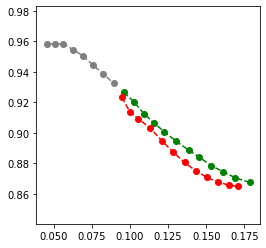

(0.0067840856223682815, 0.007802774336704677)


In [ ]:
n=40
print_trayectoria(X,y,results,n)
print(average_displacement_error(results[n],y[n]))

Ejemplo de trayectoria real vrs predicción con datos denormalizados y error de la muestra:

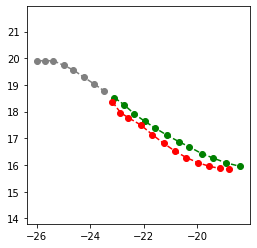

(26.502628450943874, 24.178789073661004)


In [ ]:
n=40
print_trayectoria(X_denormalized,Y_denormalized,results_denormalized,n)
print(average_displacement_error(results_denormalized[n],y[n]))

**Error ADE, FDE del training data:**

In [ ]:
#calculo de error de las trayectorias ADE, FDE con datos denormalizados
ADE_Training, FDE_Training = calculate_error_batch(results_denormalized,Y_denormalized)
print("ADE:",ADE_Training, "FDE:",FDE_Training)

ADE: 0.6313444242910486 FDE: 1.1912572918064521


#####Evaluación del modelo MLP con datos de prueba

Extacción y carga de Test Data

Test Data contiene 423 trayectorias de peatones

In [ ]:
df_test = pd.read_csv('/content/drive/MyDrive/ProyectoSL2/data/standford-dataset-meters/test/bookstore_3.txt',sep=' ', header=None, names=['time','id','x','y'])

df_test.describe(include="all")

,time,id,x,y
count,8460.000000,8460.000000,8460.000000,8460.000000
mean,7846.879433,211.000000,-2.098361,-1.368573
std,4228.993127,122.116458,14.998730,12.236613
min,0.000000,0.000000,-27.486000,-20.879000
25%,3912.000000,105.000000,-19.021000,-13.469000
50%,7716.000000,211.000000,0.059000,-4.437500
75%,11640.000000,317.000000,10.752000,10.400000
max,14484.000000,422.000000,23.401000,20.664000


Normalización de datos de prueba:

In [ ]:
#Normalizar datos de test
id_column_test = df_test.id
df_test.drop(columns=['time','id'], axis=1, inplace=True) #se quita la feature time del dataset

df_test = pd.DataFrame(scaler.fit_transform(df_test), columns=df_test.columns)
df_test['id'] = id_column_test


In [ ]:
#división de features x, y para utilizarlos en el modelo de entrada multiple
X_test, y_test = sequences_to_supervised(df_test, n_steps_in, n_steps_out, n_features)

#####Metricas del modelo con datos de prueba

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1, batch_size=8)

print("\n")
print(model.metrics_names)
print(score)

53/53 [==============================] - 2s 30ms/step - loss: 2.5774e-04


['loss']
0.000257743988186121


In [ ]:
#prediccion
results_test = model.predict(X_test)

In [ ]:
results_test = results_test.reshape(results_test.shape[0], 12, 2)


Denormalización de datos:

In [ ]:
#redimensionamiento para tener un array en 2D y poder denormalizar X
X_test_denormalized = np.array(X_test)
X_test_denormalized = X_test_denormalized.reshape(X_test_denormalized.shape[0]*X_test_denormalized.shape[1],X_denormalized.shape[2])
X_test_denormalized =  scaler.inverse_transform(X_test_denormalized)
X_test_denormalized = X_test_denormalized.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Y
Y_test_denormalized = np.array(y_test)
Y_test_denormalized = Y_test_denormalized.reshape(Y_test_denormalized.shape[0]*Y_test_denormalized.shape[1],Y_test_denormalized.shape[2])
Y_test_denormalized =  scaler.inverse_transform(Y_test_denormalized)
Y_test_denormalized = Y_test_denormalized.reshape(y_test.shape[0],y_test.shape[1],y_test.shape[2])

#redimensionamiento para tener un array en 2D y poder denormalizar Results
results_test_denormalized = np.array(results_test)
results_test_denormalized = results_test_denormalized.reshape(results_test_denormalized.shape[0]*results_test_denormalized.shape[1],results_test_denormalized.shape[2])
results_test_denormalized =  scaler.inverse_transform(results_test_denormalized)
results_test_denormalized = results_test_denormalized.reshape(results_test.shape[0],results_test.shape[1],results_test.shape[2])



**Error ADE, FDE del test data:**

In [ ]:
#calculo de error de las trayectorias ADE, FDE con datos denormalizados
ADE_Test, FDE_Test = calculate_error_batch(results_test_denormalized,Y_test_denormalized)
print("ADE:",ADE_Test, "FDE:",FDE_Test)

ADE: 0.6909170202545438 FDE: 1.318574503561969


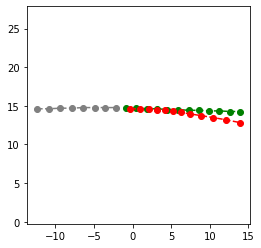

(15.52028009616693, 18.469791780953447)


In [ ]:
n=10
print_trayectoria(X_test_denormalized,Y_test_denormalized,results_test_denormalized,n)
print(average_displacement_error(results_test_denormalized[n],y[n]))